In [1]:
# %%
import numpy as np
import pandas as pd
import sys
import os
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:

# Добавляем путь к нашей песочнице если нужно
current_dir = os.getcwd()  # путь к notebooks
optimization_path = r"src"
if optimization_path not in sys.path:
    sys.path.append(optimization_path)

In [3]:
from src.spore_tree_config import SporeTreeConfig
from src.spore_tree import SporeTree
from src.pendulum import PendulumSystem
from src.visualize_spore_tree import visualize_spore_tree
from src.area_opt.tree_area_evaluator import TreeAreaEvaluator

In [4]:
from src.pairs.time_profiler import StageProfiler
from src.pairs.find_optimal_pairs_profiled import find_optimal_pairs_profiled

from src.area_opt.get_tree_area import get_tree_area
from src.area_opt.create_distance_constraints import create_distance_constraints, test_constraints
from src.area_opt.optimize_tree_area import optimize_tree_area

from src.pairs.complete_meeting_analysis import complete_meeting_analysis
from src.pairs.create_chronological_meetings import create_chronological_meetings
from src.pairs.optimize_grandchild_parent_distance import optimize_grandchild_parent_distance
from src.pairs.optimize_grandchild_pair_distance import optimize_grandchild_pair_distance
from src.pairs.find_optimal_pairs import find_optimal_pairs
from src.pairs.extract_optimal_times_from_pairs import extract_optimal_times_from_pairs
from src.pairs.create_tree_from_pairs import create_tree_from_pairs


from src.pairs.extract_pairs_from_chronology import (
    extract_pairs_from_chronology,
    get_pair_details,
    analyze_pair_statistics,
    export_pairs_to_csv
)
from src.pairs.create_meeting_chronology import (
    create_meeting_chronology,
    export_chronology_to_csv,
    get_meeting_recommendations
)
from src.pairs.build_distance_tables import (
    build_grandchild_distance_tables,
    build_grandchild_parent_distance_tables
)
from src.pairs.compute_convergence_tables import (
    compute_distance_derivative_table,
    compute_grandchild_parent_convergence_table
)
from src.pairs.find_converging_pairs import (
    find_converging_grandchild_pairs,
    find_converging_grandchild_parent_pairs
)
from src.pairs.extract_optimal_dt_from_pairs import (
    extract_optimal_dt_from_pairs,
    create_optimized_tree_from_pairs,
    compare_trees_distances
)

In [5]:
def draw_rk(pendulum, state, control, N = 50, total_dt=0.01, show=False):
    poses = [state]
    dt = total_dt/N
    for i in range(1, N+1):
        poses.append(pendulum.step(poses[-1], control, dt))

    return np.array(poses)

In [6]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.05,
    max_control=2.0
)

init_position = np.array([np.pi/2*0 , 0])

cfg = SporeTreeConfig(
    initial_position=init_position,
    dt_base=0.1,
    dt_grandchildren_factor=0.1,
    figure_size=(10, 15)
)
cfg.validate()

True

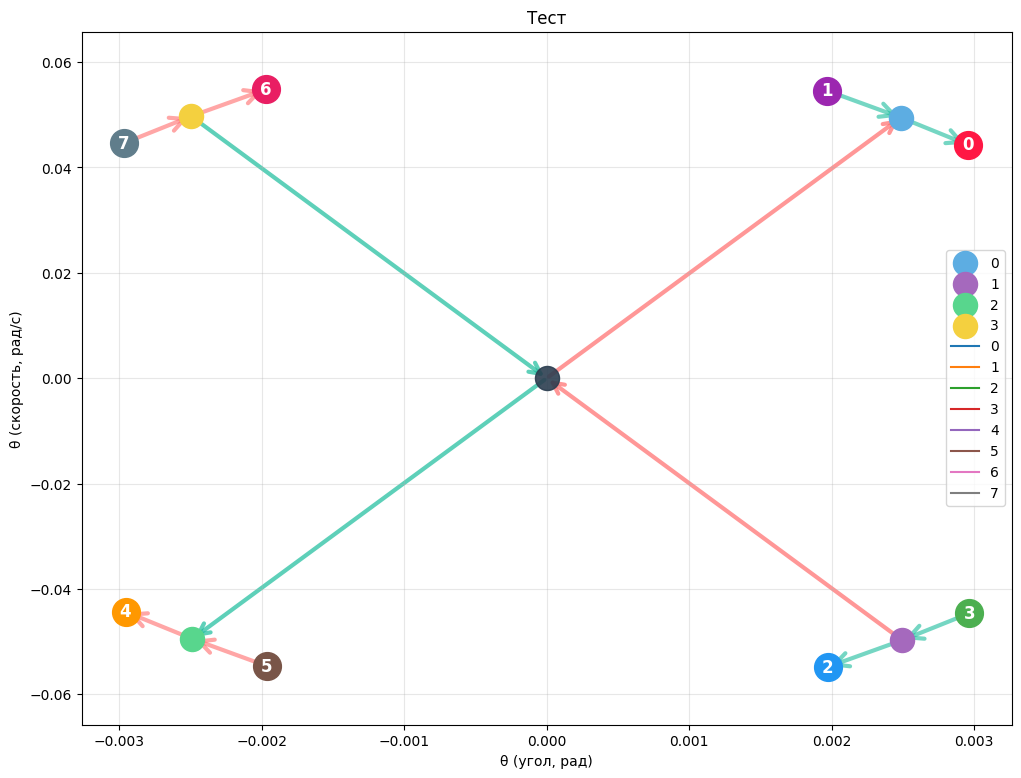

In [7]:
tree = SporeTree(pendulum, cfg)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()

# ──────────────────────────────────────────────────────────────────────
# 2. Кэш-оценщик на основе дерева
# ──────────────────────────────────────────────────────────────────────
visualize_spore_tree(tree, "Тест")


poses = []
# dts = [0.01, 0.005, 0.003, 0.003, 0.01, 0.006, 0.003, 0.003]
dts = [1.5, -0.07897676, 0.07897674, -0.9, 0.00, 0.00, 0.00, 0.000] 
dts = np.array(dts) *0

for i in range(len(grandchildren)):
    parent_pos = children[grandchildren[i]['parent_idx']]['position']
    sign = grandchildren[i]['dt'] / grandchildren[i]['dt_abs']
    control = grandchildren[i]['control']
    poses_1 = draw_rk(pendulum, state=parent_pos, control=control, total_dt=dts[i])

    plt.plot(poses_1[:, 0], poses_1[:, 1], label=f'{i}')

plt.legend()


Создано дерево с 4 парами


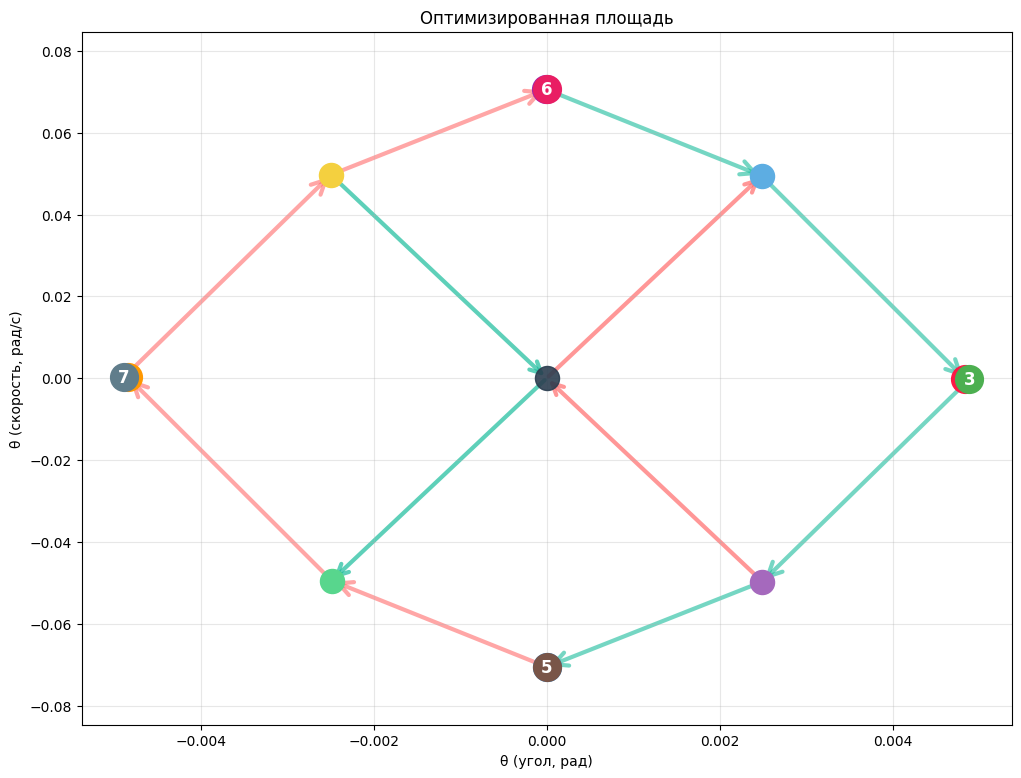

In [8]:
pairs = find_optimal_pairs(tree, show=False)
# Полный дебаг
result = create_tree_from_pairs(tree, pendulum, cfg, show=False)

# Проверка результата
if result and result['success']:
    paired_tree = result['optimized_tree']
    print(f"Создано дерево с {result['stats']['pairs_found']} парами")
else:
    print(f"Ошибка: {result['error'] if result else 'критическая ошибка'}")

visualize_spore_tree(paired_tree, "Оптимизированная площадь")

In [9]:
get_tree_area(paired_tree)

0.0008338062989352195

0.0062104895389295


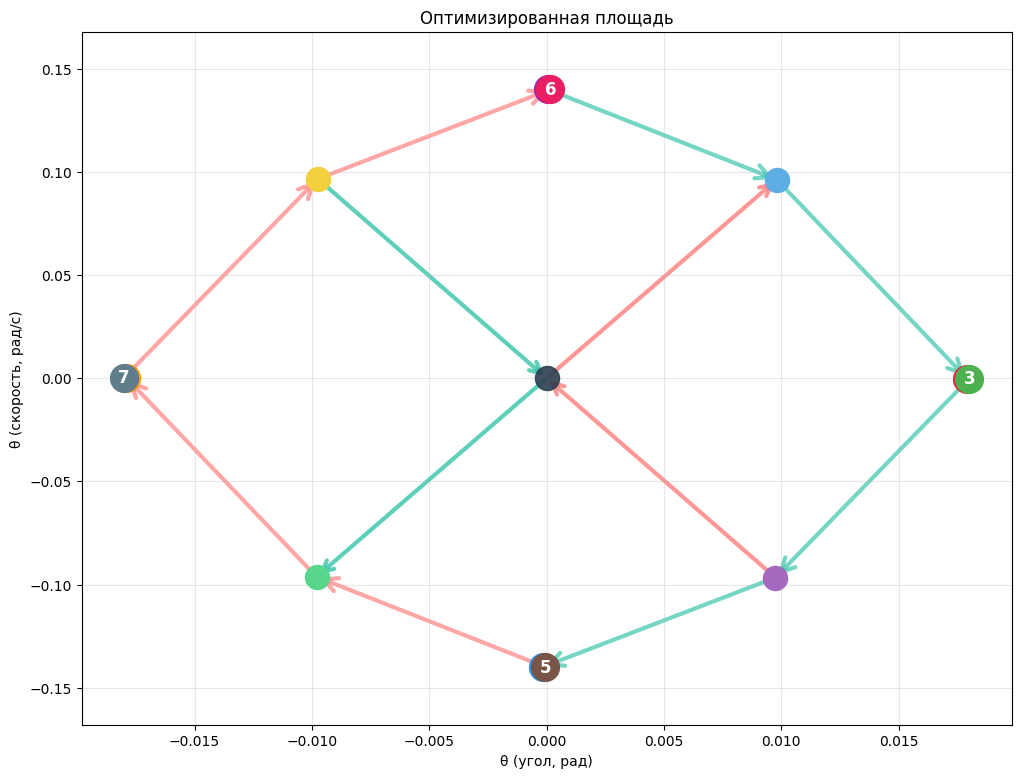

In [10]:
result = optimize_tree_area(
            tree=paired_tree,
            pairs=pairs, 
            optimization_method='SLSQP',
            pendulum=pendulum,
            constraint_distance=1e-4,  # Максимальное расстояние между парами
            max_iterations=1500,
            dt_bounds=(0.001, 0.2),
            show=False  # Показать весь процесс
        )

if result['success']:
    optimized_tree = result['optimized_tree']
    print(get_tree_area(optimized_tree))
    visualize_spore_tree(optimized_tree, "Оптимизированная площадь")
else:
    print(f"Ошибка: {result}")